# 1. Data Preprocessing

## 1.1 Data Cleaning

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# List of file paths
file_names = [
    "interventions_bxl.parquet.gzip",
    "interventions_bxl2.parquet.gzip",
    "interventions1.parquet.gzip",
    "interventions2.parquet.gzip",
    "interventions3.parquet.gzip"
]

# Read files
dfs = [pd.read_parquet(file_name) for file_name in file_names]

# Process the 'EventType and EventLevel' column in the second DataFrame
df2 = dfs[1]
df2['event type trip'] = df2['EventType and EventLevel'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
df2['event level trip'] = df2['EventType and EventLevel'].apply(lambda x: x.split()[1] if isinstance(x, str) else None)

# Convert 'T0' and 'T3' columns to datetime format and calculate 'waiting time'
date_format = "%d%b%y:%H:%M:%S"
df2['T0'] = pd.to_datetime(df2['T0'], format=date_format, errors='coerce')
df2['T3'] = pd.to_datetime(df2['T3'], format=date_format, errors='coerce')
df2['waiting time'] = (df2['T3'] - df2['T0']).dt.total_seconds() // 60  # Keep to the nearest minute

# Standardize column names
column_mapping = [
    {'abandon_reason': 'abandon reason', 'waiting_time': 'waiting time', 'Eventlevel_trip': 'event level trip', 'vector_type': 'vector type', 'eventtype_trip': 'event type trip'},
    {'Abandon reason NL': 'abandon reason', 'Vector type NL': 'vector type'},
    {'Abandon reason': 'abandon reason', 'Waiting time': 'waiting time', 'EventType Trip': 'event type trip', 'EventLevel Trip': 'event level trip', 'Vector type': 'vector type'},
    {'Abandon reason': 'abandon reason', 'Waiting time': 'waiting time', 'EventType Trip': 'event type trip', 'EventLevel Trip': 'event level trip', 'Vector type': 'vector type'},
    {'Abandon reason': 'abandon reason', 'Waiting time': 'waiting time', 'EventType Trip': 'event type trip', 'EventLevel Trip': 'event level trip', 'Vector type': 'vector type'}
]

for i, df in enumerate(dfs):
    df.rename(columns=column_mapping[i], inplace=True)

# Process 'abandon reason' column: remove null values and encode
for i, df in enumerate(dfs):
    df.dropna(subset=['abandon reason'], inplace=True)
    if i == 1:
        df['abandon reason'] = df['abandon reason'].apply(lambda x: 1 if x == 'Dood Ter Plaatse' else 0)
    else:
        df['abandon reason'] = df['abandon reason'].apply(lambda x: 1 if x == 'Overleden' else 0)

# Extract rows where 'event type trip' column starts with P039 or P003
filtered_dfs = []

for i, df in enumerate(dfs):
    filtered_df = df[df['event type trip'].str.startswith(('P039', 'P003'), na=False)]
    filtered_dfs.append(filtered_df)
    print(f"DataFrame {i+1} extracted rows:", filtered_df.shape[0])

# Extract the four columns of interest and merge
selected_columns = ['waiting time', 'event level trip', 'vector type', 'abandon reason']
merged_df = pd.concat([df[selected_columns] for df in filtered_dfs if all(col in df.columns for col in selected_columns)], ignore_index=True)

# Remove null values in 'waiting time' column
merged_df.dropna(subset=['waiting time'], inplace=True)

# Check the total number of rows in the merged DataFrame
print("Total rows in the merged DataFrame:", len(merged_df))

# Check for null values in the merged DataFrame
print("Null values in the merged DataFrame:")
print(merged_df.isnull().sum())

# Check the descriptive statistics of the merged DataFrame for outliers
print("\nDescriptive statistics of the merged DataFrame:")
print(merged_df.describe())

# Print the first few rows of the merged DataFrame
print("\nSample data from the merged DataFrame:")
print(merged_df.head())

# One-hot encode categorical variables
categorical_features = ['event level trip', 'vector type']
numeric_features = ['waiting time']

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

# Preprocess the data
X = merged_df.drop(columns=['abandon reason'])
y = merged_df['abandon reason']
X_preprocessed = preprocessor.fit_transform(X)

# Print the shape and type of the preprocessed data
print("X_preprocessed shape:", X_preprocessed.shape)
print("X_preprocessed type:", type(X_preprocessed))
print("y shape:", y.shape)
print("y type:", type(y))

# Handle data imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_preprocessed, y)

# Print the shape and type of the resampled data
print("X_res shape:", X_res.shape)
print("X_res type:", type(X_res))
print("y_res shape:", y_res.shape)
print("y_res type:", type(y_res))

DataFrame 1 extracted rows: 801
DataFrame 2 extracted rows: 114
DataFrame 3 extracted rows: 1419
DataFrame 4 extracted rows: 1261
DataFrame 5 extracted rows: 1525
Total rows in the merged DataFrame: 3694
Null values in the merged DataFrame:
waiting time        0
event level trip    0
vector type         0
abandon reason      0
dtype: int64

Descriptive statistics of the merged DataFrame:
       waiting time  abandon reason
count   3694.000000     3694.000000
mean      13.397401        0.725772
std       12.421719        0.446185
min        1.000000        0.000000
25%        9.000000        0.000000
50%       11.000000        1.000000
75%       15.000000        1.000000
max      447.000000        1.000000

Sample data from the merged DataFrame:
   waiting time event level trip vector type  abandon reason
0          11.0              N05         AMB               0
2           8.0              N01         AMB               1
3           8.0              N05         AMB               0
4

## 1.2 Feature Engineering

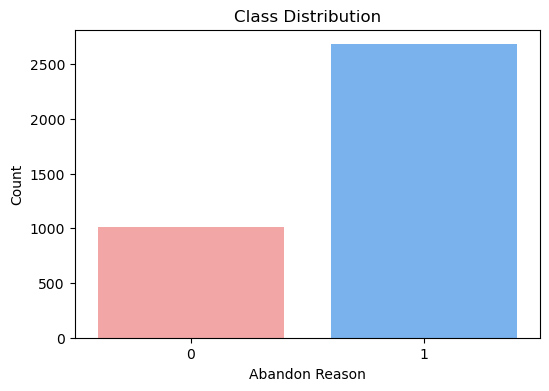

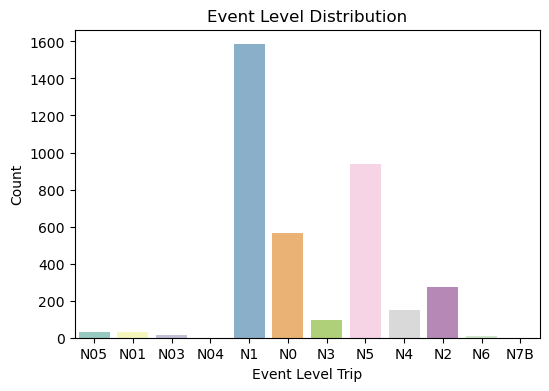

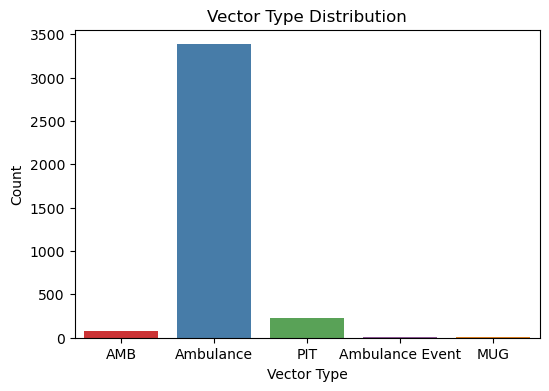

E:\Pyrhon\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


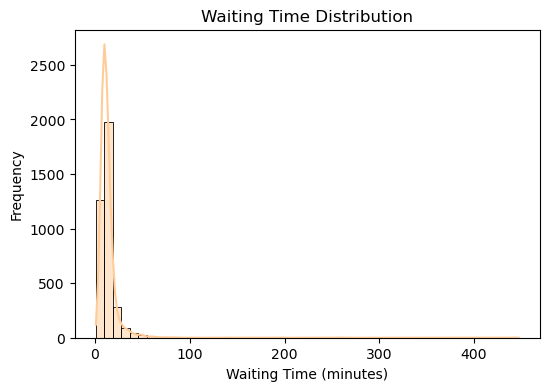

X_preprocessed shape: (3694, 18)
X_preprocessed type: <class 'scipy.sparse._csr.csr_matrix'>
y shape: (3694,)
y type: <class 'pandas.core.series.Series'>
X_res shape: (5362, 18)
X_res type: <class 'scipy.sparse._csr.csr_matrix'>
y_res shape: (5362,)
y_res type: <class 'pandas.core.series.Series'>
Number of selected features (variance threshold): 3
Number of selected features (based on tree model importance): 5


In [11]:
# Class distribution visualization
plt.figure(figsize=(6, 4))
sns.countplot(x='abandon reason', data=merged_df, palette=['#FF9999', '#66B2FF'])
plt.title('Class Distribution')
plt.xlabel('Abandon Reason')
plt.ylabel('Count')
plt.show()

# Feature distribution visualization
# Event level distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='event level trip', data=merged_df, palette='Set3')
plt.title('Event Level Distribution')
plt.xlabel('Event Level Trip')
plt.ylabel('Count')
plt.show()

# Vector type distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='vector type', data=merged_df, palette='Set1')
plt.title('Vector Type Distribution')
plt.xlabel('Vector Type')
plt.ylabel('Count')
plt.show()

# Waiting time distribution
plt.figure(figsize=(6, 4))
sns.histplot(merged_df['waiting time'], bins=50, kde=True, color='#FFCC99')
plt.title('Waiting Time Distribution')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.show()

# One-hot encode categorical variables
categorical_features = ['event level trip', 'vector type']
numeric_features = ['waiting time']

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)

# Preprocess the data
X = merged_df.drop(columns=['abandon reason'])
y = merged_df['abandon reason']
X_preprocessed = preprocessor.fit_transform(X)

# Print the shape and type of the preprocessed data
print("X_preprocessed shape:", X_preprocessed.shape)
print("X_preprocessed type:", type(X_preprocessed))
print("y shape:", y.shape)
print("y type:", type(y))

# Handle data imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_preprocessed, y)

# Print the shape and type of the resampled data
print("X_res shape:", X_res.shape)
print("X_res type:", type(X_res))
print("y_res shape:", y_res.shape)
print("y_res type:", type(y_res))

# Feature engineering
# Feature selection (variance threshold)
selector = VarianceThreshold(threshold=0.1)
X_res_var = selector.fit_transform(X_res)

# Check the number of selected features
print("Number of selected features (variance threshold):", X_res_var.shape[1])

# Feature selection based on feature importance (tree model)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_res, y_res)
selector = SelectFromModel(clf, threshold="mean")
X_res_important = selector.fit_transform(X_res, y_res)

# Check the number of selected features
print("Number of selected features (based on tree model importance):", X_res_important.shape[1])

# Feature interactions
interaction_features = pd.DataFrame(X_res.toarray(), columns=preprocessor.get_feature_names_out())
interaction_features['waiting_time_event_level'] = interaction_features['num__waiting time'] * interaction_features['cat__event level trip_N01']
interaction_features['waiting_time_vector_type'] = interaction_features['num__waiting time'] * interaction_features['cat__vector type_AMB']

# Update the feature matrix
X_res_interaction = np.hstack((X_res.toarray(), interaction_features[['waiting_time_event_level', 'waiting_time_vector_type']]))

# Feature transformation
interaction_features['log_waiting_time'] = np.log1p(interaction_features['num__waiting time'])
X_res_transformed = np.hstack((X_res_interaction, interaction_features[['log_waiting_time']]))

## 1.3 Data Augmentation

In [12]:
# Data augmentation (SMOTE)
smote = SMOTE(random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X_res_transformed, y_res)

# Data augmentation (ADASYN)
adasyn = ADASYN(random_state=42)
X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X_res_transformed, y_res)

# Save the processed data to CSV
X_res_adasyn_df = pd.DataFrame(X_res_adasyn, columns=preprocessor.get_feature_names_out().tolist() + ['waiting_time_event_level', 'waiting_time_vector_type', 'log_waiting_time'])
y_res_adasyn_df = pd.DataFrame(y_res_adasyn, columns=['abandon reason'])

X_res_adasyn_df.to_csv('X_res_adasyn.csv', index=False)
y_res_adasyn_df.to_csv('y_res_adasyn.csv', index=False)

# Data split
X_train, X_temp, y_train, y_temp = train_test_split(X_res_adasyn, y_res_adasyn, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Save data for later model use
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

print("Data saved, ready for model training.")

Data saved, ready for model training.


# 2. Model Training, Preditcing and Evaluating

## 2.1 Random Forest

### 2.1.1 Model Training, Preditcing and Evaluating

[I 2024-05-30 17:57:43,269] A new study created in memory with name: no-name-b9672f5a-077d-4188-ad3a-18ab9f4914ef
[I 2024-05-30 17:57:51,618] Trial 0 finished with value: 0.7990945406125166 and parameters: {'n_estimators': 621, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7990945406125166.
[I 2024-05-30 17:58:02,717] Trial 1 finished with value: 0.7990945406125166 and parameters: {'n_estimators': 709, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.7990945406125166.
[I 2024-05-30 17:58:05,582] Trial 2 finished with value: 0.7953651131824234 and parameters: {'n_estimators': 194, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7990945406125166.
[I 2024-05-30 17:58:14,822] Trial 3 finished with value: 0.7956300044385264 and parameters: {'n_estimators': 330, 'max_depth': 15,

Random Forest Best parameters found:  {'n_estimators': 747, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Accuracy: 0.7748756218905473
Precision: 0.8111111111111111
Recall: 0.7209876543209877
F1-Score: 0.7633986928104575
ROC-AUC Score: 0.8417587177821096
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79       399
           1       0.81      0.72      0.76       405

    accuracy                           0.77       804
   macro avg       0.78      0.78      0.77       804
weighted avg       0.78      0.77      0.77       804

Confusion Matrix:
 [[331  68]
 [113 292]]


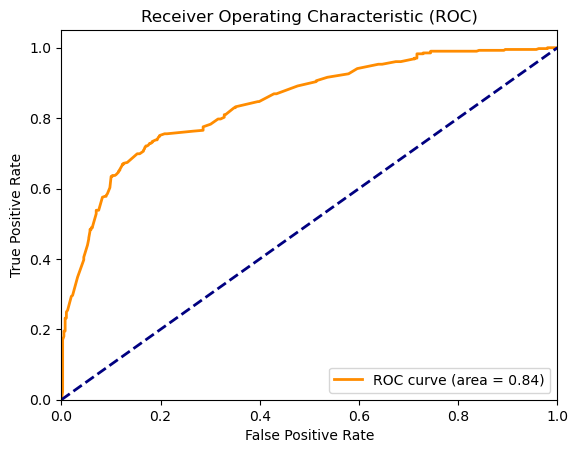

Accuracy: 0.7801242236024845
Precision: 0.7882037533512064
Recall: 0.75
F1-Score: 0.7686274509803922
ROC-AUC Score: 0.8230221870830656
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79       413
           1       0.79      0.75      0.77       392

    accuracy                           0.78       805
   macro avg       0.78      0.78      0.78       805
weighted avg       0.78      0.78      0.78       805

Confusion Matrix:
 [[334  79]
 [ 98 294]]


In [14]:
# randomforest
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Load data
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# Define the objective function for Random Forest
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    
    model = RandomForestClassifier(**param, random_state=42)
    
    # Use K-fold cross-validation for model evaluation
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()

# Start optimizing Random Forest
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

# Print the best parameters
print("Random Forest Best parameters found: ", study_rf.best_params)

# Train the Random Forest model with the best parameters
best_params_rf = study_rf.best_params
model_rf = RandomForestClassifier(**best_params_rf, random_state=42)
model_rf.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_rf = model_rf.predict(X_val)
y_val_proba_rf = model_rf.predict_proba(X_val)[:, 1]

# Compute and print additional evaluation metrics
def evaluate_model(y_true, y_pred, y_proba=None):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        print("ROC-AUC Score:", roc_auc)
    
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Print additional evaluation metrics for the validation set
evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Predict on the test set
y_test_pred_rf = model_rf.predict(X_test)
y_test_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Print additional evaluation metrics for the test set
evaluate_model(y_test, y_test_pred_rf, y_test_proba_rf)


### 2.1.2 Visualizing Important Features

Feature ranking:
1. feature 'cat__event level trip_N1' (0.2501054593757319)
2. feature 'cat__event level trip_N0' (0.18292541956480265)
3. feature 'cat__event level trip_N5' (0.1310521901644742)
4. feature 'cat__event level trip_N4' (0.11285757906987988)
5. feature 'log_waiting_time' (0.08131874745133247)
6. feature 'num__waiting time' (0.08063395170085198)
7. feature 'cat__event level trip_N3' (0.057847641852307986)
8. feature 'cat__vector type_Ambulance' (0.024417934916388166)
9. feature 'cat__event level trip_N2' (0.022012888710815994)
10. feature 'cat__vector type_AMB' (0.012774866988354533)
11. feature 'cat__vector type_PIT' (0.010150978407136106)
12. feature 'waiting_time_vector_type' (0.010108739688086331)
13. feature 'cat__event level trip_N05' (0.008223629316033007)
14. feature 'waiting_time_event_level' (0.005175365193124117)
15. feature 'cat__event level trip_N01' (0.0045053109979214575)
16. feature 'cat__event level trip_N03' (0.003329530115163847)
17. feature 'cat__vector 

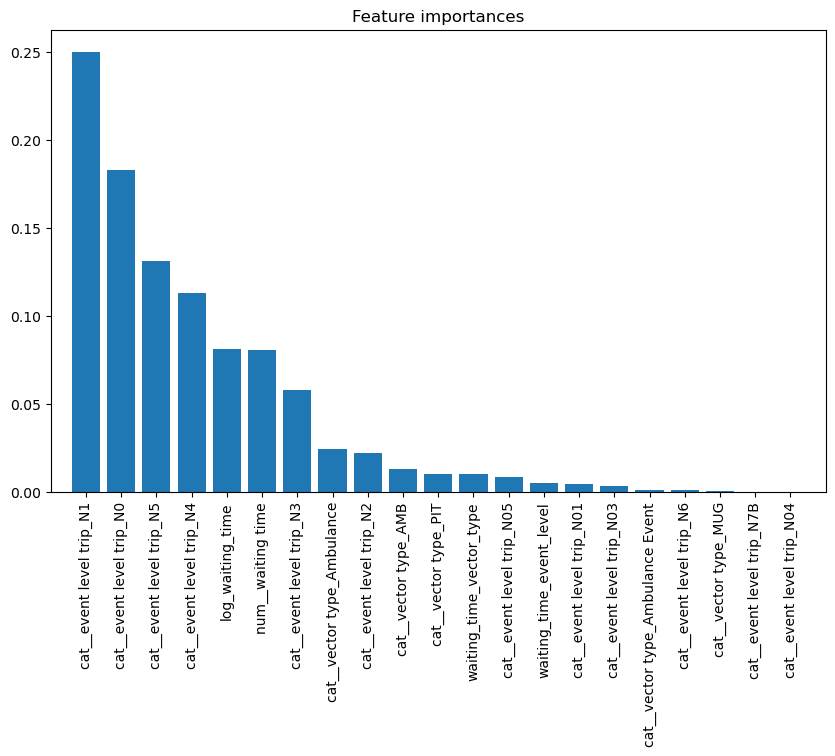

In [16]:
# Extract original feature names
original_feature_names = preprocessor.get_feature_names_out()

# Add new feature names (interaction features and transformed features)
interaction_feature_names = [
    'waiting_time_event_level', 
    'waiting_time_vector_type', 
    'log_waiting_time'
]

# Combine all feature names
all_feature_names = list(original_feature_names) + interaction_feature_names

# Ensure the length of feature names matches the number of columns in the feature matrix
assert len(all_feature_names) == X_train.shape[1], "Feature names length does not match the number of features."

# Get feature importances
feature_importances = model_rf.feature_importances_

# Sort feature importances
indices = np.argsort(feature_importances)[::-1]

# Print feature importances
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. feature '{all_feature_names[index]}' ({feature_importances[index]})")

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [all_feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


## 2.2 XGBoost

### 2.2.1 Model Training, Preditcing and Evaluating

[I 2024-05-30 18:15:28,122] A new study created in memory with name: no-name-3f58b19b-a79c-4fc8-85a4-ad6d1006a0f0
C:\Users\75269\AppData\Local\Temp\ipykernel_9140\4053812779.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2024-05-30 18:15:31,243] Trial 0 finished with value: 0.8041580115401686 and parameters: {'n_estimators': 321, 'max_depth': 7, 'learning_rate': 0.10588503457648894, 'subsample': 0.7360072752198734, 'colsample_bytree': 0.7172698726371278, 'gamma': 0.3790783832678869}. Best is trial 0 with value: 0.8041580115401686.
C:\Users\75269\AppData\Local\Temp\ipykernel_9140\4053812779.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

XGBoost Best parameters found:  {'n_estimators': 538, 'max_depth': 10, 'learning_rate': 0.26572149739176615, 'subsample': 0.7708494971051798, 'colsample_bytree': 0.7118136500916253, 'gamma': 0.18852368147980852}
Accuracy: 0.777363184079602
Precision: 0.8192090395480226
Recall: 0.7160493827160493
F1-Score: 0.764163372859025
ROC-AUC Score: 0.8361552028218694
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.84      0.79       399
           1       0.82      0.72      0.76       405

    accuracy                           0.78       804
   macro avg       0.78      0.78      0.78       804
weighted avg       0.78      0.78      0.78       804

Confusion Matrix:
 [[335  64]
 [115 290]]


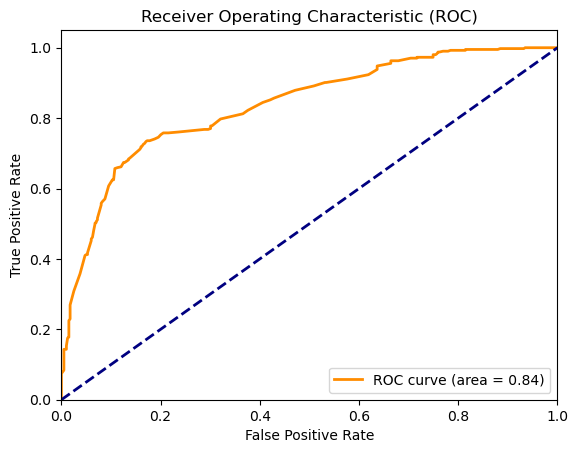

Accuracy: 0.7813664596273292
Precision: 0.7918918918918919
Recall: 0.7474489795918368
F1-Score: 0.7690288713910761
ROC-AUC Score: 0.8229110045955428
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79       413
           1       0.79      0.75      0.77       392

    accuracy                           0.78       805
   macro avg       0.78      0.78      0.78       805
weighted avg       0.78      0.78      0.78       805

Confusion Matrix:
 [[336  77]
 [ 99 293]]


In [18]:
# xgboost
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Load data
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# Define the objective function for XGBoost
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5)
    }
    
    model = XGBClassifier(**param, random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    # Use K-fold cross-validation for model evaluation
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()

# Start optimizing XGBoost
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)

# Print the best parameters
print("XGBoost Best parameters found: ", study_xgb.best_params)

# Train the XGBoost model with the best parameters
best_params_xgb = study_xgb.best_params
model_xgb = XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_xgb = model_xgb.predict(X_val)
y_val_proba_xgb = model_xgb.predict_proba(X_val)[:, 1]

# Compute and print additional evaluation metrics
def evaluate_model(y_true, y_pred, y_proba=None):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        print("ROC-AUC Score:", roc_auc)
    
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Print additional evaluation metrics for the validation set
evaluate_model(y_val, y_val_pred_xgb, y_val_proba_xgb)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Predict on the test set
y_test_pred_xgb = model_xgb.predict(X_test)
y_test_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Print additional evaluation metrics for the test set
evaluate_model(y_test, y_test_pred_xgb, y_test_proba_xgb)


### 2.2.2 Visualizing Important Features

Feature ranking:
1. feature 'cat__event level trip_N03' (0.23798306286334991)
2. feature 'cat__event level trip_N05' (0.1739443689584732)
3. feature 'cat__event level trip_N0' (0.11819674074649811)
4. feature 'cat__event level trip_N4' (0.09792687743902206)
5. feature 'cat__event level trip_N1' (0.0654124990105629)
6. feature 'cat__event level trip_N3' (0.05106901749968529)
7. feature 'cat__event level trip_N5' (0.03597492724657059)
8. feature 'cat__vector type_Ambulance' (0.03161204978823662)
9. feature 'cat__event level trip_N01' (0.030408108606934547)
10. feature 'cat__vector type_AMB' (0.025656746700406075)
11. feature 'log_waiting_time' (0.02075050212442875)
12. feature 'waiting_time_event_level' (0.019266316667199135)
13. feature 'num__waiting time' (0.017412500455975533)
14. feature 'cat__event level trip_N2' (0.017202483490109444)
15. feature 'waiting_time_vector_type' (0.01698656938970089)
16. feature 'cat__vector type_PIT' (0.015443357639014721)
17. feature 'cat__vector type_

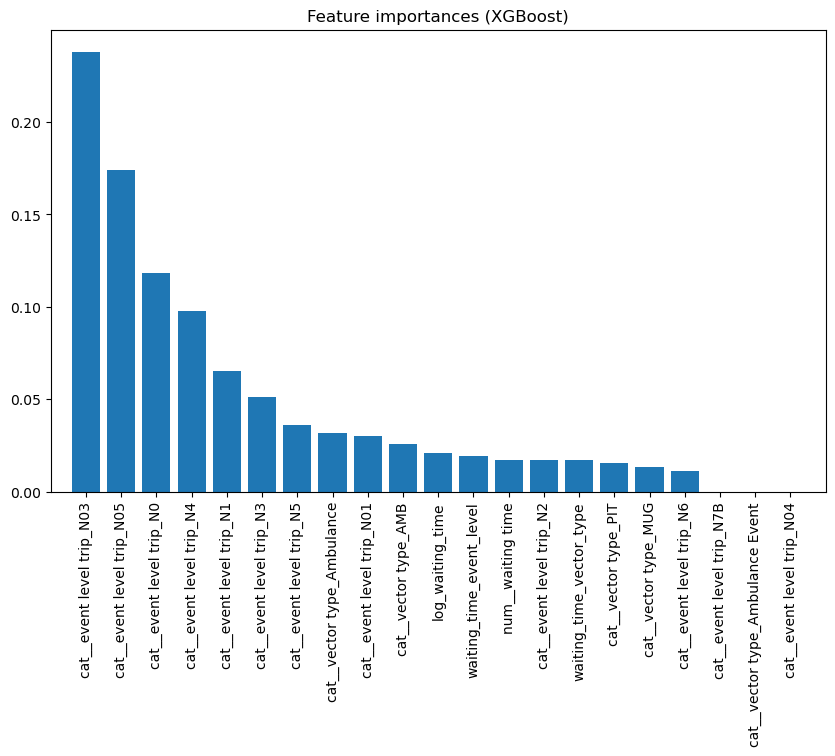

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract original feature names
original_feature_names = preprocessor.get_feature_names_out()

# Add new feature names (interaction features and transformed features)
interaction_feature_names = [
    'waiting_time_event_level', 
    'waiting_time_vector_type', 
    'log_waiting_time'
]

# Combine all feature names
all_feature_names = list(original_feature_names) + interaction_feature_names

# Ensure the length of feature names matches the number of columns in the feature matrix
assert len(all_feature_names) == X_train.shape[1], "Feature names length does not match the number of features."

# Get feature importances
feature_importances = model_xgb.feature_importances_

# Sort feature importances
indices = np.argsort(feature_importances)[::-1]

# Print feature importances
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. feature '{all_feature_names[index]}' ({feature_importances[index]})")

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances (XGBoost)")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [all_feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


## 2.3 CatBoost

### 2.3.1 Model Training, Predicting and Evaluating

[I 2024-05-30 18:32:52,976] A new study created in memory with name: no-name-04848e9a-7ddf-48ce-b263-742f31d88d1e
C:\Users\75269\AppData\Local\Temp\ipykernel_9140\556865763.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
[I 2024-05-30 18:33:12,050] Trial 0 finished with value: 0.7956310696848646 and parameters: {'iterations': 785, 'depth': 6, 'learning_rate': 0.0223689561883491, 'l2_leaf_reg': 82.00899861586839, 'border_count': 194, 'bagging_temperature': 0.6167045183762417}. Best is trial 0 with value: 0.7956310696848646.
C:\Users\75269\AppData\Local\Temp\ipykernel_9140\556865763.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

CatBoost Best parameters found:  {'iterations': 274, 'depth': 5, 'learning_rate': 0.09336298665303877, 'l2_leaf_reg': 0.9960371505446801, 'border_count': 56, 'bagging_temperature': 0.16424236732978215}
Accuracy: 0.7786069651741293
Precision: 0.8161559888579387
Recall: 0.7234567901234568
F1-Score: 0.7670157068062827
ROC-AUC Score: 0.8510133358086575
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79       399
           1       0.82      0.72      0.77       405

    accuracy                           0.78       804
   macro avg       0.78      0.78      0.78       804
weighted avg       0.78      0.78      0.78       804

Confusion Matrix:
 [[333  66]
 [112 293]]


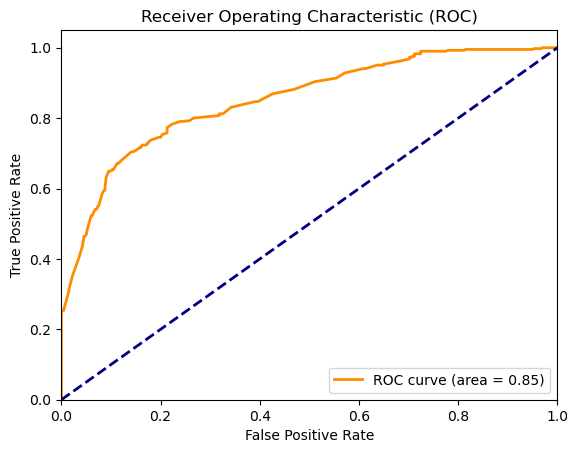

Accuracy: 0.7850931677018633
Precision: 0.792
Recall: 0.7576530612244898
F1-Score: 0.7744458930899609
ROC-AUC Score: 0.8290970746652172
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       413
           1       0.79      0.76      0.77       392

    accuracy                           0.79       805
   macro avg       0.79      0.78      0.78       805
weighted avg       0.79      0.79      0.78       805

Confusion Matrix:
 [[335  78]
 [ 95 297]]


In [22]:
from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Load data
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

# Define the objective function for CatBoost
def objective_cat(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e2),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1)
    }
    
    model = CatBoostClassifier(**param, random_state=42, verbose=0)
    
    # Use K-fold cross-validation for model evaluation
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()

# Start optimizing CatBoost
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=50)

# Print the best parameters
print("CatBoost Best parameters found: ", study_cat.best_params)

# Train the CatBoost model with the best parameters
best_params_cat = study_cat.best_params
model_cat = CatBoostClassifier(**best_params_cat, random_state=42, verbose=0)
model_cat.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_cat = model_cat.predict(X_val)
y_val_proba_cat = model_cat.predict_proba(X_val)[:, 1]

# Compute and print additional evaluation metrics
def evaluate_model(y_true, y_pred, y_proba=None):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        print("ROC-AUC Score:", roc_auc)
    
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Print additional evaluation metrics for the validation set
evaluate_model(y_val, y_val_pred_cat, y_val_proba_cat)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_cat)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Predict on the test set
y_test_pred_cat = model_cat.predict(X_test)
y_test_proba_cat = model_cat.predict_proba(X_test)[:, 1]

# Print additional evaluation metrics for the test set
evaluate_model(y_test, y_test_pred_cat, y_test_proba_cat)


### 2.3.2 Visualizing Important Features

CatBoost Feature ranking:
1. feature 'cat__event level trip_N0' (23.50870033292526)
2. feature 'cat__event level trip_N1' (17.4984190465369)
3. feature 'cat__event level trip_N4' (16.808177675000916)
4. feature 'num__waiting time' (10.708622190736104)
5. feature 'log_waiting_time' (10.242752035653627)
6. feature 'cat__event level trip_N3' (4.946087500996314)
7. feature 'cat__vector type_PIT' (2.9049543535722218)
8. feature 'cat__event level trip_N2' (2.7164075938835803)
9. feature 'cat__event level trip_N5' (2.377716489698895)
10. feature 'cat__vector type_Ambulance' (2.281639811183333)
11. feature 'waiting_time_vector_type' (2.037116332919197)
12. feature 'cat__event level trip_N01' (1.156300866561815)
13. feature 'cat__event level trip_N05' (1.0510299841504196)
14. feature 'waiting_time_event_level' (0.585413085546516)
15. feature 'cat__event level trip_N03' (0.5263960053465143)
16. feature 'cat__vector type_AMB' (0.19239312292277513)
17. feature 'cat__vector type_Ambulance Event' (0

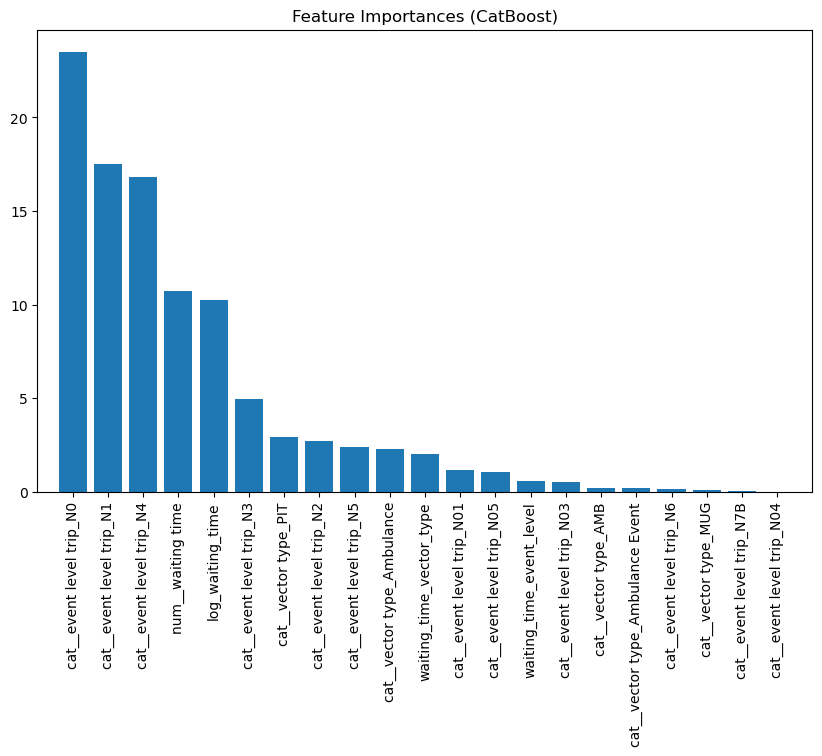

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract original feature names
original_feature_names = preprocessor.get_feature_names_out()

# Add new feature names (interaction features and transformed features)
interaction_feature_names = [
    'waiting_time_event_level', 
    'waiting_time_vector_type', 
    'log_waiting_time'
]

# Combine all feature names
all_feature_names = list(original_feature_names) + interaction_feature_names

# Ensure the length of feature names matches the number of columns in the feature matrix
assert len(all_feature_names) == X_train.shape[1], "Feature names length does not match the number of features."

# Get feature importances from the CatBoost model
cat_feature_importances = model_cat.get_feature_importance()

# Sort feature importances
cat_indices = np.argsort(cat_feature_importances)[::-1]

# Print feature importances from the CatBoost model
print("CatBoost Feature ranking:")
for i, index in enumerate(cat_indices):
    print(f"{i + 1}. feature '{all_feature_names[index]}' ({cat_feature_importances[index]})")

# Visualize feature importances from the CatBoost model
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (CatBoost)")
plt.bar(range(X_train.shape[1]), cat_feature_importances[cat_indices], align="center")
plt.xticks(range(X_train.shape[1]), [all_feature_names[i] for i in cat_indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


# 3. Model Comparision

## 3.1 Comparing Confusion Matrix

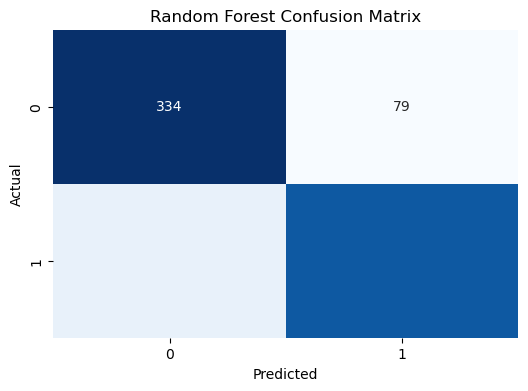

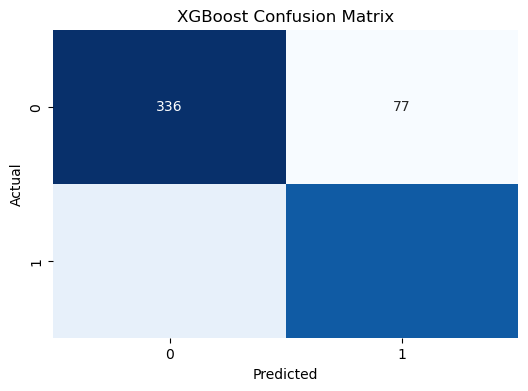

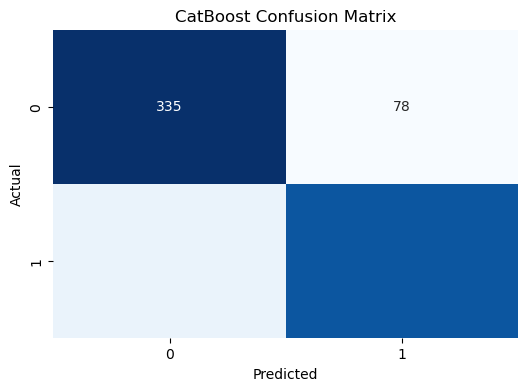

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, title, figsize=(6, 4)):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Use the previously calculated prediction results
y_test_pred_rf = model_rf.predict(X_test)
y_test_pred_xgb = model_xgb.predict(X_test)
y_test_pred_cat = model_cat.predict(X_test)

# Plot confusion matrix for Random Forest model
plot_confusion_matrix(y_test, y_test_pred_rf, 'Random Forest Confusion Matrix', figsize=(6, 4))

# Plot confusion matrix for XGBoost model
plot_confusion_matrix(y_test, y_test_pred_xgb, 'XGBoost Confusion Matrix', figsize=(6, 4))

# Plot confusion matrix for CatBoost model
plot_confusion_matrix(y_test, y_test_pred_cat, 'CatBoost Confusion Matrix', figsize=(6, 4))



## 3.2 Comparing ROC-AUC Curve

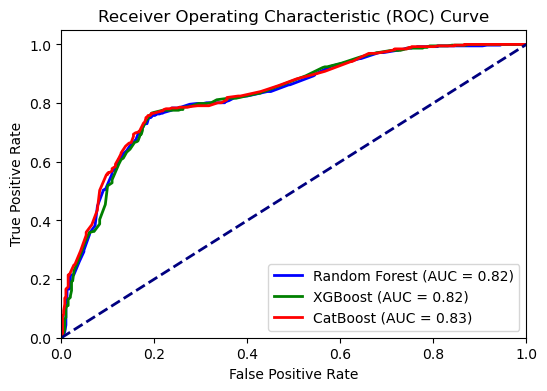

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test, y_test_proba_rf, y_test_proba_xgb, y_test_proba_cat are defined
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_cat, tpr_cat, _ = roc_curve(y_test, y_test_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_cat, tpr_cat, color='red', lw=2, label=f'CatBoost (AUC = {roc_auc_cat:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## 3.3 Compare Accuracy, Precision, Recall, F1 Score, and ROC-AUC Score

{'accuracy': 0.7801242236024845, 'precision': 0.7882037533512064, 'recall': 0.75, 'f1': 0.7686274509803922, 'roc_auc': 0.8230221870830656}
{'accuracy': 0.7813664596273292, 'precision': 0.7918918918918919, 'recall': 0.7474489795918368, 'f1': 0.7690288713910761, 'roc_auc': 0.8229110045955428}
{'accuracy': 0.7850931677018633, 'precision': 0.792, 'recall': 0.7576530612244898, 'f1': 0.7744458930899609, 'roc_auc': 0.8290970746652172}


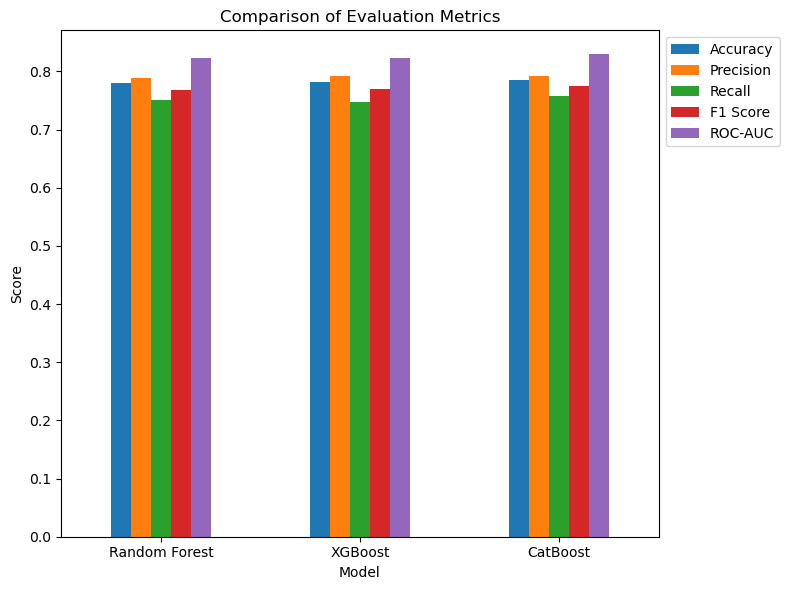

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_model(y_true, y_pred, y_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': None  # Default value is None
    }
    
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    
    return metrics

# Assuming y_test, y_test_pred_rf, y_test_proba_rf, y_test_pred_xgb, y_test_proba_xgb, y_test_pred_cat, y_test_proba_cat are defined
metrics_rf = evaluate_model(y_test, y_test_pred_rf, y_test_proba_rf)
metrics_xgb = evaluate_model(y_test, y_test_pred_xgb, y_test_proba_xgb)
metrics_cat = evaluate_model(y_test, y_test_pred_cat, y_test_proba_cat)

# Print to check the returned values
print(metrics_rf)
print(metrics_xgb)
print(metrics_cat)

# Ensure all metrics are present
metrics_dict = {
    'Accuracy': [metrics_rf['accuracy'], metrics_xgb['accuracy'], metrics_cat['accuracy']],
    'Precision': [metrics_rf['precision'], metrics_xgb['precision'], metrics_cat['precision']],
    'Recall': [metrics_rf['recall'], metrics_xgb['recall'], metrics_cat['recall']],
    'F1 Score': [metrics_rf['f1'], metrics_xgb['f1'], metrics_cat['f1']],
    'ROC-AUC': [metrics_rf['roc_auc'], metrics_xgb['roc_auc'], metrics_cat['roc_auc']]
}

# Create DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Random Forest', 'XGBoost', 'CatBoost'])

# Plot comparison chart
fig, ax = plt.subplots(figsize=(8, 6))  # Increase figure size for better readability
metrics_df.plot(kind='bar', ax=ax)
plt.title('Comparison of Evaluation Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout() 
plt.show()

